Sample data:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Device set to use mps:0



Sentiment distribution:
 Sentiment
negative    210
positive     73
Name: count, dtype: int64

Train: 203, Test: 51, Unseen: 29

Balanced training distribution:
 Sentiment
negative    150
positive    150
Name: count, dtype: int64

===== Naive Bayes =====
Accuracy (Test): 0.7255
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82        38
    positive       0.46      0.46      0.46        13

    accuracy                           0.73        51
   macro avg       0.64      0.64      0.64        51
weighted avg       0.73      0.73      0.73        51



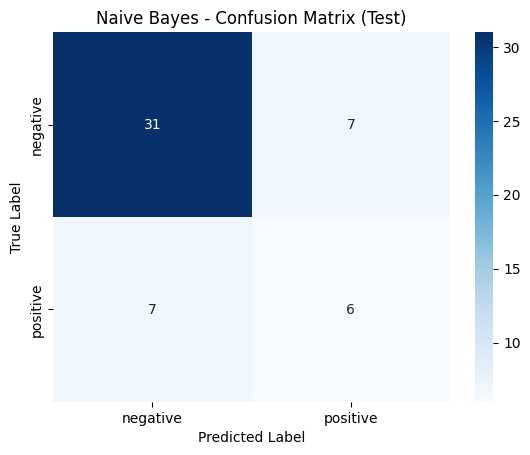


===== Logistic Regression =====
Accuracy (Test): 0.8431
              precision    recall  f1-score   support

    negative       0.83      1.00      0.90        38
    positive       1.00      0.38      0.56        13

    accuracy                           0.84        51
   macro avg       0.91      0.69      0.73        51
weighted avg       0.87      0.84      0.82        51



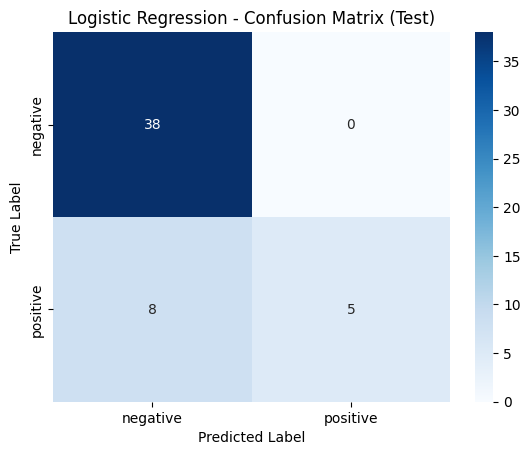


===== Final Evaluation on Unseen Data (Naive Bayes) =====
Accuracy (Unseen): 0.6897
              precision    recall  f1-score   support

    negative       0.76      0.86      0.81        22
    positive       0.25      0.14      0.18         7

    accuracy                           0.69        29
   macro avg       0.51      0.50      0.50        29
weighted avg       0.64      0.69      0.66        29



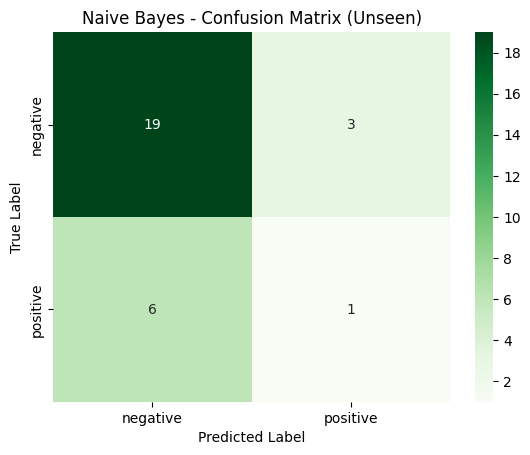


===== Final Evaluation on Unseen Data (Logistic Regression) =====
Accuracy (Unseen): 0.7241
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84        22
    positive       0.00      0.00      0.00         7

    accuracy                           0.72        29
   macro avg       0.38      0.48      0.42        29
weighted avg       0.57      0.72      0.64        29



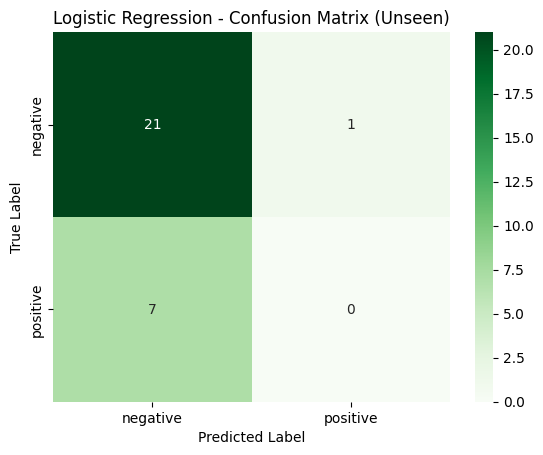


TOP 10 MOST NEGATIVE COMMENTS


,Comments,Negative Probability
1,Start the Judicial Process ! Put all those Guilty of Graft & Corruption to Death Penalty,0.737
2,All of its funds for Davao are now gone like a wasted money. Ghost projects regarding 51 billion nakaw funds is like a ghost employees of the Davao LGU in which the Dutertes ruled the area because all of the Duterte's ghost employees are getting involved in the illegal drug activities. A mess is also a mess which cannot be fixed or to resolve. Ikulong na yan ang mga kurakot!,0.716
3,Who's who .. reveals who walks free.. isn’t just about corruption — it’s about the network that Protects it.A strategic cover up to a corrupt systems for the political survival.,0.708
4,"yes! never allow to normalize and make corruption acceptable to Filipino people, speak what is right and should be, boldly at all times.",0.704
5,People got FOOLED to focus on the impeachment instead if the corruption going on.,0.700
6,"Still waiting for the first one to either go to jail, or return the money, or do the rework on these flood control projects! Stop acting like enough na yung palabas niyo sa TV - we need accountability. And that means doing the right thing after you mess up",0.687
7,"Hindi climate change yan. Abuse ng Mother Nature: air pollution, water pollution, deforestation, misused of minerals, killing of animals, sins of mankind. Lack of appreciation to the Creator for His Creation.",0.678
8,Wala nang staff o tauhan si DPWH secretary. Naubos yata dahil forced to resign dahil involved lahat sa graft and corruption? 😅,0.677
9,The Department of Finance denies having a P28.7 billion loan. Hmmm… I think someone tries to loan from SK without the knowledge of the DOF.,0.675
10,who's the inspector who signed the papers na tapos na ang project and also released the payment money? 😒,0.641



TOP 10 MOST POSITIVE COMMENTS


,Comments,Positive Probability
1,UST tanggalin nyo na as Alumuns yang mga Engineer na yan na corrupt! Pag nagawa nyo yan dapat ibang school mag follow. Unless may pakinabang kayo Sa nga yan.,0.501
2,Nice louder,0.498
3,Sana next na cancelin yung ayuda at tupad. Ang dami ding corruption sa programang yan.,0.445
4,"I live nearby, ang weird kasi mataas na area na yan. Drainage lang talaga problem.",0.445
5,😢😢😢😢😢😢,0.441
6,🤮🤮🤮 Kakapal!!!,0.431
7,nice para naman ibang issue nanaman ibato ng mga DDS sa pangulo hanap ulit sila ng paninira sa gobyerno at pangulo nyan haha,0.430
8,Kapal mo Engineer nag enjoy ka din demanding kapa!!! Balik ka parin sa Senadp tanggalan ng Lisensya lahat ng Kumain sa Lamesa ng Kaban Ng Bayan sa Maling paraan!!!!!!🤬,0.427
9,"Prayer for the most corrupt official in our government today. Ipagdasal natin ang duwag nating speaker na kumuha na ng spokesperson kasi umurong na ang bayag niya… Prayer for the House of Represent-The-Thieves: St. Martin Patron Saint of Insertion, PAY for us…Deliver us our money…Walang a-amen 😇",0.427
10,Peste ka BBM!??!ikaw?? you're the first Mahiya,0.419


In [ ]:
# ==============================
# Sentiment Analysis with SMOTE + Hugging Face Pseudo-Labels
# ==============================


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from transformers import pipeline

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("comments.csv")   # your dataset (1 column: "Comments")
df = df.dropna(subset=["Comments"])  # drop empty rows

print("Sample data:\n", df.head())

# ==============================
# 2. Generate Pseudo-Labels
# ==============================
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

def get_sentiment(text):
    try:
        result = sentiment_model(str(text))[0]
        return result['label'].lower()  # returns 'positive' or 'negative'
    except:
        return "neutral"

df["Sentiment"] = df["Comments"].apply(get_sentiment)

# Keep only positive & negative
df = df[df["Sentiment"].isin(["positive", "negative"])]
print("\nSentiment distribution:\n", df["Sentiment"].value_counts())

# ==============================
# 3. Train-Test-Unseen Split
# ==============================
train_df, unseen_df = train_test_split(
    df, test_size=0.10, stratify=df['Sentiment'], random_state=42
)
train_df, test_df = train_test_split(
    train_df, test_size=0.20, stratify=train_df['Sentiment'], random_state=42
)

print(f"\nTrain: {len(train_df)}, Test: {len(test_df)}, Unseen: {len(unseen_df)}")

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Comments'])
y_train = train_df['Sentiment']
X_test = vectorizer.transform(test_df['Comments'])
y_test = test_df['Sentiment']
X_unseen = vectorizer.transform(unseen_df['Comments'])
y_unseen = unseen_df['Sentiment']

# ==============================
# 5. Apply SMOTE Oversampling
# ==============================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\nBalanced training distribution:\n", pd.Series(y_train_bal).value_counts())

# ==============================
# 6. Train Models
# ==============================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy (Test): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {
        "model": model,
        "test_acc": acc
    }

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# ==============================
# 7. Evaluate on Unseen Data
# ==============================
for name, res in results.items():
    print(f"\n===== Final Evaluation on Unseen Data ({name}) =====")
    model = res["model"]
    y_pred_unseen = model.predict(X_unseen)
    acc_unseen = accuracy_score(y_unseen, y_pred_unseen)
    print(f"Accuracy (Unseen): {acc_unseen:.4f}")
    print(classification_report(y_unseen, y_pred_unseen))

    cm = confusion_matrix(y_unseen, y_pred_unseen, labels=["negative", "positive"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
    plt.title(f"{name} - Confusion Matrix (Unseen)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# ==============================
# 8. Show Top Positive & Negative Comments (Top 10 each in Tables)
# ==============================
best_model = results["Logistic Regression"]["model"]
probs = best_model.predict_proba(X_unseen)

unseen_df["Prob_Negative"] = probs[:, 0]
unseen_df["Prob_Positive"] = probs[:, 1]

# Get top 10 for each
top_neg = unseen_df.sort_values(by="Prob_Negative", ascending=False).head(10)[["Comments", "Prob_Negative"]]
top_pos = unseen_df.sort_values(by="Prob_Positive", ascending=False).head(10)[["Comments", "Prob_Positive"]]

# Round probabilities for readability
top_neg["Prob_Negative"] = top_neg["Prob_Negative"].round(3)
top_pos["Prob_Positive"] = top_pos["Prob_Positive"].round(3)

# Rename columns for better display
top_neg_display = top_neg.rename(columns={"Prob_Negative": "Negative Probability"})
top_pos_display = top_pos.rename(columns={"Prob_Positive": "Positive Probability"})

# Reset index to start from 1
top_neg_display.reset_index(drop=True, inplace=True)
top_pos_display.reset_index(drop=True, inplace=True)
top_neg_display.index = range(1, len(top_neg_display) + 1)
top_pos_display.index = range(1, len(top_pos_display) + 1)

# ==============================
# Display as Excel-style Tables
# ==============================
print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE COMMENTS")
print("="*80)

# Style the negative comments table
styled_neg = top_neg_display.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ffcccc'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).format({'Negative Probability': '{:.3f}'})

display(styled_neg)

print("\n" + "="*80)
print("TOP 10 MOST POSITIVE COMMENTS")
print("="*80)

# Style the positive comments table
styled_pos = top_pos_display.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ccffcc'), ('color', 'black'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
]).format({'Positive Probability': '{:.3f}'})

display(styled_pos)
